In [1]:
#Load the data using pandas
#Import all the required packages
import pandas as pd
import numpy as np
import io
import requests
import matplotlib.pyplot as plt

#Reading the content from the HTML page using requests package
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
data = requests.get(url).content

#Splitting the data into rows and columns
cleanedData = data.decode('utf-8').split('\n')
rowsAndColumns = [each.split(',') for each in cleanedData]

#Adding a header to the data
header = ['sLength','sWidth','pLength','pWidth','class']
#The final dataframe
df = pd.DataFrame(rowsAndColumns, columns = header)
df = df.loc[0:149,:]

print(df.tail())
#df.to_csv('Iris.csv')

    sLength sWidth pLength pWidth           class
145     6.7    3.0     5.2    2.3  Iris-virginica
146     6.3    2.5     5.0    1.9  Iris-virginica
147     6.5    3.0     5.2    2.0  Iris-virginica
148     6.2    3.4     5.4    2.3  Iris-virginica
149     5.9    3.0     5.1    1.8  Iris-virginica


In [2]:
#Converting values ro numeric
numeric = ['sLength','sWidth','pLength','pWidth']
for each in numeric:
    df[each] = df[each].astype('float')
print(df.describe())

          sLength      sWidth     pLength      pWidth
count  150.000000  150.000000  150.000000  150.000000
mean     5.843333    3.054000    3.758667    1.198667
std      0.828066    0.433594    1.764420    0.763161
min      4.300000    2.000000    1.000000    0.100000
25%      5.100000    2.800000    1.600000    0.300000
50%      5.800000    3.000000    4.350000    1.300000
75%      6.400000    3.300000    5.100000    1.800000
max      7.900000    4.400000    6.900000    2.500000


In [3]:
#Checking for na values in any rows
print("NA's present : ",df.isnull().any().any())

NA's present :  False


In [4]:
#Train/Test split
from sklearn.model_selection import train_test_split

x = df.loc[:,df.columns != 'class']
y = df.loc[:,df.columns == 'class']

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.30, random_state=15)

#Used for cross validation
train = pd.concat([xTrain, yTrain], axis=1)
test = pd.concat([xTest, yTest], axis=1)

In [5]:
# Split a dataset based on an attribute and an attribute value
def testSplit(index, value, dataset):
    left, right = [], []
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return (left,right)

In [6]:
# Calculate the Gini index for a split dataset
def giniCalc(groups, classes):
    # count all samples at split point
    total = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / total)
    return gini

In [59]:
# Calculate the Gini index for a split dataset
def crossEntropy(groups, classes):
    # count all samples at split point
    total = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    ig = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * np.log(p)
        # weight the group score by its relative size
        ig += (1.0 -score) * (size / total)
    return ig

In [20]:
def ig(s):
    gain = 0
    val, counts = np.unique(s, return_counts=True)
    freqs = counts.astype('float')/len(s)
    for p in freqs:
        if p != 0.0:
            gain -= p * np.log2(p)
    return gain

In [54]:
# Select the best split point for a dataset
def split1(dataset):
    import matplotlib.pyplot as plt
    giniList,crossList = [],[]
    class_values = list(set(row[-1] for row in dataset))
    tempIndex, tempValue, tempScore, tempGroups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = testSplit(index, row[index], dataset)
            gini = crossEntropy(groups, class_values)
            crossList.append(gini)
            gini1 = giniCalc(groups,class_values)
            giniList.append(gini1)
            if gini < tempScore:
                tempIndex, tempValue, tempScore, tempGroups = index, row[index], gini, groups
    plt.plot(giniList,'o',color = 'r',label = 'Gini')
    plt.plot(crossList,'o',color = 'g',label = 'Cross Entropy')
    plt.title("Gini and Cross Entropy")
    plt.legend()
    plt.show()
    return {'index':tempIndex, 'value':tempValue, 'groups':tempGroups}

In [10]:
def to_terminal(group):
    out = [row[-1] for row in group]
    return max(set(out), key=out.count)

In [46]:
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = split1(left)
        split(node['left'], max_depth, min_size, depth+1)
        temp1 = split1(left)
        class_values1 = list(set(row[-1] for row in temp1))
        probability(temp1['groups'],class_values1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = split1(right)
        split(node['right'], max_depth, min_size, depth+1)
        temp2 = split1(right)
        class_values2 = list(set(row[-1] for row in temp2))
        probability(temp2['groups'],class_values2)

In [12]:
def recursiveTree(train, max_depth, min_size):
    root = split1(train)
    class_values3 = list(set(row[-1] for row in root))
    #print(root['groups'])
    probability(root['groups'],class_values3)
    split(root, max_depth, min_size, 1)
    return root

In [13]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']


In [39]:
# Classification and Regression Tree Algorithm
def decisionTree(train, test, max_depth, min_size):
    tree = recursiveTree(train, max_depth, min_size)
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)

In [15]:
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

In [16]:
def probability(listA,classesList):
    import collections
    import matplotlib.pyplot as plt
    original = ['Iris-setosa','Iris-virginica', 'Iris-versicolor']
    for eachSplit in listA:
        classes,keys,values = [],[],[]
        for each in eachSplit:
            classes.append(each[-1])
        counter=collections.Counter(classes)
        temp3 = dict(counter)
        temp3.setdefault("Iris-setosa",0)
        temp3.setdefault("Iris-virginica",0)
        temp3.setdefault("Iris-versicolor",0)
        #print(temp3)
        for key in temp3.keys():
            keys.append(key)
            values.append(float(temp3[key]/(len(eachSplit)+1e-15)))
        print(keys,values)
        #print(eachSplit)
        bar_width = 0.0005
        plt.bar(np.arange(len(keys)),values,color='b')
        plt.xticks(np.arange(len(keys)) + bar_width, keys)
        plt.ylabel("Probability")
        plt.show()
        igValue = ig(eachSplit)
        print("IG : ",igValue)

/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


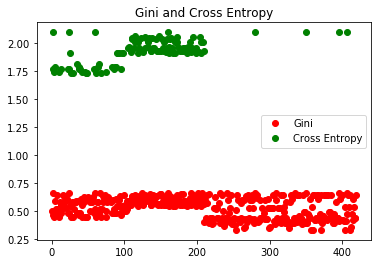

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'] [0.8205128205128205, 0.15384615384615385, 0.02564102564102564]


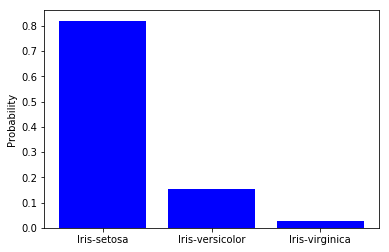

IG :  12.9073576403
['Iris-virginica', 'Iris-versicolor', 'Iris-setosa'] [0.5303030303030303, 0.42424242424242425, 0.045454545454545456]


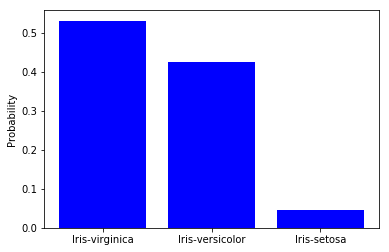

IG :  16.2230186507


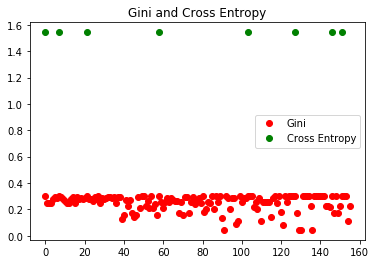

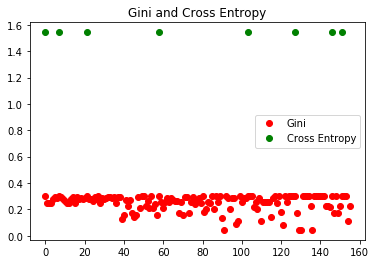

['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'] [0.0, 0.0, 0.0]


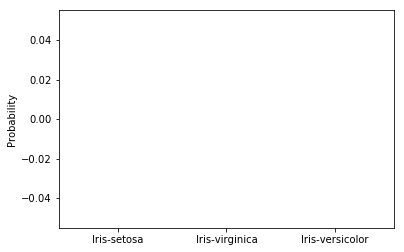

IG :  0
['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'] [0.8205128205128205, 0.15384615384615385, 0.02564102564102564]


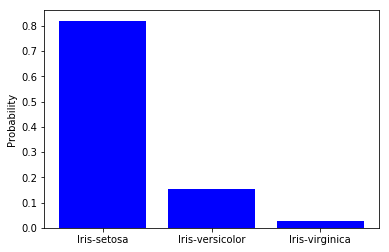

IG :  12.9073576403


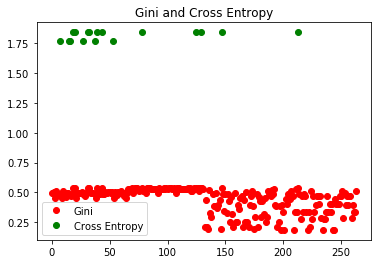

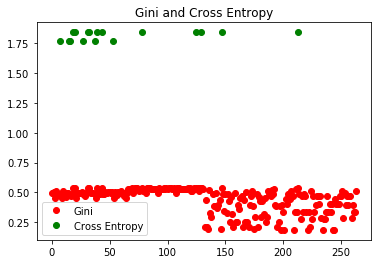

['Iris-virginica', 'Iris-versicolor', 'Iris-setosa'] [0.16666666666666663, 0.6666666666666665, 0.16666666666666663]


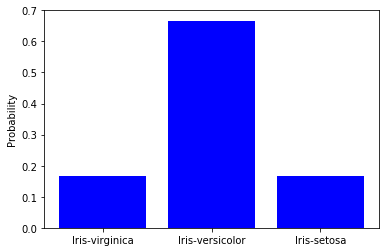

IG :  10.7057132967
['Iris-virginica', 'Iris-versicolor', 'Iris-setosa'] [0.6111111111111112, 0.37037037037037035, 0.018518518518518517]


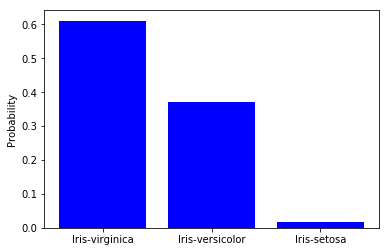

IG :  15.5760936123
[X1 < 5.600]
 [X1 < 4.400]
  [Iris-setosa]
  [Iris-setosa]
 [X1 < 5.800]
  [Iris-versicolor]
  [Iris-virginica]


In [65]:
tree = recursiveTree(train.values.tolist(), 2, 1)
print_tree(tree)
#predictionGini = decisionTree(train.values.tolist(),test.values.tolist(),3,1)


In [56]:
print(tree)

{'index': 0, 'value': 5.6, 'left': {'index': 0, 'value': 4.4, 'left': 'Iris-setosa', 'right': 'Iris-setosa'}, 'right': {'index': 0, 'value': 5.8, 'left': {'index': 0, 'value': 5.6, 'left': 'Iris-versicolor', 'right': 'Iris-versicolor'}, 'right': {'index': 0, 'value': 5.8, 'left': 'Iris-virginica', 'right': 'Iris-virginica'}}}


In [ ]:
def prune(tree,mingain):
    flag1,flag2 = True,True
    mergedLeft,mergedRight = [],[]
     # If the branches aren't leaves, then prune them
    left = tree['left']
    if (isinstance(left, dict)):
        flag1 = False
    right = tree['right']
    if (isinstance(right, dict)):
        flag2 = False
    if (flag1 and flag2):
        for eachSplit in left['groups']:
            mergedLeft.append(eahSplit)
        for eachSplit in right['groups']:
            mergedRight.append(eahSplit)
        leftGain = ig(mergedLeft)
        rightGain = ig(mergedRight)
        totalGain = ig(mergedLeft+mergedRight)
        print("left child Gain : ", leftGain)
        print("right child Gain : ", rightGain)
        print("parent child Gain : ", totalGain)
        if(leftGain+rightGain) > totalGain:
            del(tree['right'])
            del(tree['left'])

In [ ]:
print(tree1)